In [1]:
from __future__ import division
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import gmres, minres, cg
import scipy.sparse.linalg as spla
import time
import math
np.set_printoptions(suppress=True)
plt.rc('font',family='serif')
%matplotlib inline

In [2]:
# Obtain xl,xr positions for each element
def get_xlxr(mesh):
    xlxr=np.zeros((len(mesh)-1,2))
    xlxr[:,0]=mesh[:-1]
    xlxr[:,1]=mesh[1:]
    return xlxr

### 1. PBE Model

$\frac{\partial F}{\partial t} + \frac{\partial}{\partial V}(F \frac{dV}{dt}) = 0$

$F(V,0|\mu,{\sigma}^2) = \frac{1}{\sqrt{2\pi {\sigma}^2}}e^{-\frac{(V-\mu)^2}{2\sigma ^2}}$

$\frac{dV}{dt} = c$

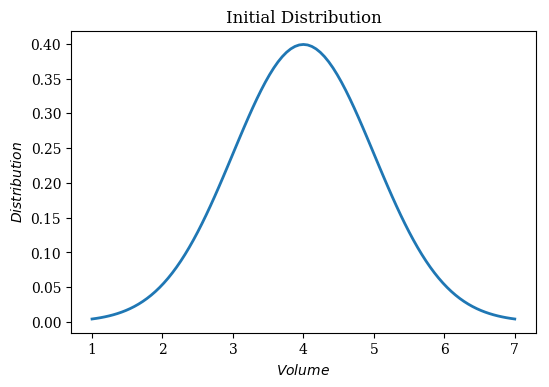

In [188]:
dvdt=0.05

a=1
b=7

# Number of elements
n=100
# Defining the mesh, ie, node positions
v0=np.linspace(a,b,n+1)
# Get pairs of points for each element 
xlxr=get_xlxr(v0)
# Time step
dt=1/100

sigma2=1
mu=4

F_init=(1/np.sqrt(2*math.pi*sigma2))*np.exp(-(v0-mu)**2/(2*sigma2))

plt.figure(num=None,figsize=(6,4),dpi=100,facecolor='w',edgecolor='k')
plt.plot(v0,F_init,lw=2)
plt.ylabel('$Distribution$')
plt.xlabel('$Volume$')
plt.title('Initial Distribution');

### 3. Weak Formulation

$\int_{\Omega ^e} w \frac{\partial F}{\partial t} dV + \int_{\Omega ^e} cw \frac{\partial}{\partial V}F dV  = 0$

$F = \sum_{j = 1}^{n} F_j(t)\Psi _j(V)$

$w = \Psi _i(V)$

$\sum_{j = 1}^{n} \int_{\Omega ^e}\Psi _i \Psi _j dV \frac{\partial F_j}{\partial t} + \sum_{j = 1}^{n} \int_{\Omega ^e} c\Psi _i \frac{\partial \Psi _j}{\partial V}dV F_j = 0$

### 4. Gaussian Quadrature 

Reference element [0,1] 

$\int_a^b f(x)dx = \int_0^1(b-a)f(a+(b-a)\xi)d\xi$

In [191]:
def reftoreal(x,a,b):
    return a+(b-a)*x


def GQintegrate(integrand):
    nodes=[0.5-1/(2*np.sqrt(3)),0.5+1/(2*np.sqrt(3))]
    weights=[0.5,0.5]
    result=0
    result+=weights[0]*integrand(nodes[0])
    result+=weights[1]*integrand(nodes[1])
    return result

In [192]:
a=1
b=5
ftest=lambda x:(1+(reftoreal(x,a,b))**2)*(b-a)
GQintegrate(ftest)

45.33333333333333

In [193]:
ftest1=lambda x:1+x**2
sp.integrate.quad(ftest1,1,5)

(45.33333333333333, 5.033011044967376e-13)

### 5. Shape functions over reference element

$\Psi_0(x)=1-x$

$\Psi_1(x)=x$

$\frac{d}{dx}\Psi_0(x)=-1$

$\frac{d}{dx}\Psi_1(x)=1$

In [194]:
# Shape functions 
def phi(node):
    shape={0:lambda x:1-x,
          1:lambda x:x}
    return shape[node]


# Derivatives of shape functions
def dphi(node):
    dphival={0:-1,
            1:1}
    return dphival[node]

### 6. Mass matrix

Local element mass matrix 
$M_{i,j}^e = \int_{\Omega ^e} \Psi _i\Psi _jJ^e dx$

Global mass matrix
$M = \sum_{e = 1}^{n}A^{eT}M^eA^e$

In [195]:
# Local element mass matrix
def localmass(element):
    a=element[0]
    b=element[1]
    M_e=np.zeros((2,2))
    J_e=b-a
    for i in range(len(element)): # Consider each node
        for j in range(i+1): # Consider each shape function
            integrand=lambda x:J_e*phi(i)(a+(b-a)*x)*phi(j)(a+(b-a)*x)
            M_e[i,j]=GQintegrate(integrand)
            M_e[j,i]=M_e[i,j]
    return M_e

In [196]:
# Assembling global mass matrix 
M=np.zeros((n+1,n+1))
for i in range(n): # Going through each element
    A=np.eye(2,n+1,i,dtype=int)
    M_e=localmass(xlxr[i])
    M+=np.transpose(A)@M_e@A    

In [197]:
print(M)

[[ 0.000072 -0.001872  0.       ...  0.        0.        0.      ]
 [-0.001872  0.064176 -0.005904 ...  0.        0.        0.      ]
 [ 0.       -0.005904  0.072672 ...  0.        0.        0.      ]
 ...
 [ 0.        0.        0.       ...  4.911072 -2.450304  0.      ]
 [ 0.        0.        0.       ... -2.450304  5.003376 -2.496672]
 [ 0.        0.        0.       ...  0.       -2.496672  2.914872]]


### 7. Stiffness Matrix

In [203]:
# Local stiffness matrix for an element
def localstiffness(element,dvdt):
    b=element[1]
    a=element[0]
    J_e=(b-a)
    K_e=np.zeros((2,2))
    for i in range(len(element)): 
        for j in range(i+1):
            integrand=lambda x:dvdt*J_e*phi(i)(a+(b-a)*x)*dphi(j)*1/J_e
            K_e[i,j]=GQintegrate(integrand)
            K_e[j,i]=K_e[i,j]
    return K_e

In [204]:
# Assembling global stiffness matrix
K=np.zeros((n+1,n+1))
for i in range(n): # Going through each elementsigma=1
    A=np.eye(2,n+1,i,dtype=int)
    K_e=localstiffness(xlxr[i],dvdt)
    K+=np.transpose(A)@K_e@A

In [205]:
# Applying Dirichlet boundary conditions
K[0,:]=np.zeros(n+1)
K[:,0]=np.zeros(n+1)
K[0,0]=1   
# M[0,:]=np.zeros(n+1)
# M[:,0]=np.zeros(n+1)
# M[0,0]=1   

### 8. Crank-Nicolson Method to time step

$F_{t+1}=(M+\frac{dt}{2}K_{t+1})^{-1}(M-\frac{dt}{2}K_t)F_t$

In [206]:
F=F_init
Fs=[F]
vs=[v0]
t=5
steps=t/dt
step=1

while step<=steps:
    F=np.linalg.inv(M+dt/2*K)@(M-dt/2*K)@F
    Fs.append(F)
    v=(dvdt*step)+v0
    vs.append(v)
    step+=1


# while step<=steps:
#     F=np.linalg.inv(M)@(M@F-dt*K@F)
#     Fs.append(F)
#     v=(dvdt*step)+v0
#     vs.append(v)
#     step+=1

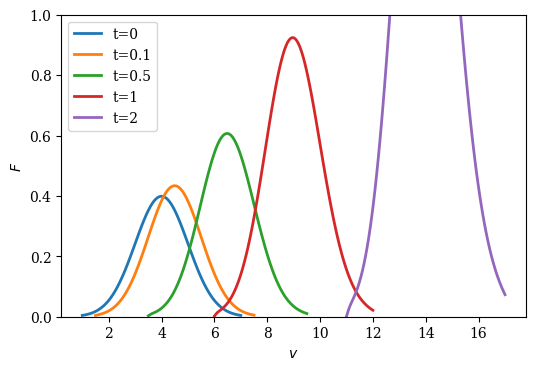

In [207]:
plt.figure(num=None,figsize=(6,4),dpi=100,facecolor='w',edgecolor='k')
plt.plot(vs[0],Fs[0],label='t=0',lw=2)
plt.plot(vs[10],Fs[10],label='t=0.1',lw=2)
plt.plot(vs[50],Fs[50],label='t=0.5',lw=2)
plt.plot(vs[100],Fs[100],label='t=1',lw=2)
plt.plot(vs[200],Fs[200],label='t=2',lw=2)
plt.ylabel('$F$')
plt.xlabel('$v$')
plt.ylim(0,1)
plt.legend();